# Seismic wave propagation modeling

In [1]:
import os
os.environ['PATH'] = "/home/riascodc/DelftOpenSource/bin:" + os.environ['PATH']

import matplotlib.pyplot as plt
import segyio
import obspy
import pickle 
from tqdm import tqdm
from scipy import interpolate, signal
from matplotlib.animation import FuncAnimation
from celluloid import Camera
from matplotlib import colors
import numpy as np
from skimage.transform import rescale, resize

path = './Data'
os.system(f'cd {path}')

with open('sources_array_times10.pkl', 'rb') as f:
    sources_dic, t_wav = pickle.load(f)

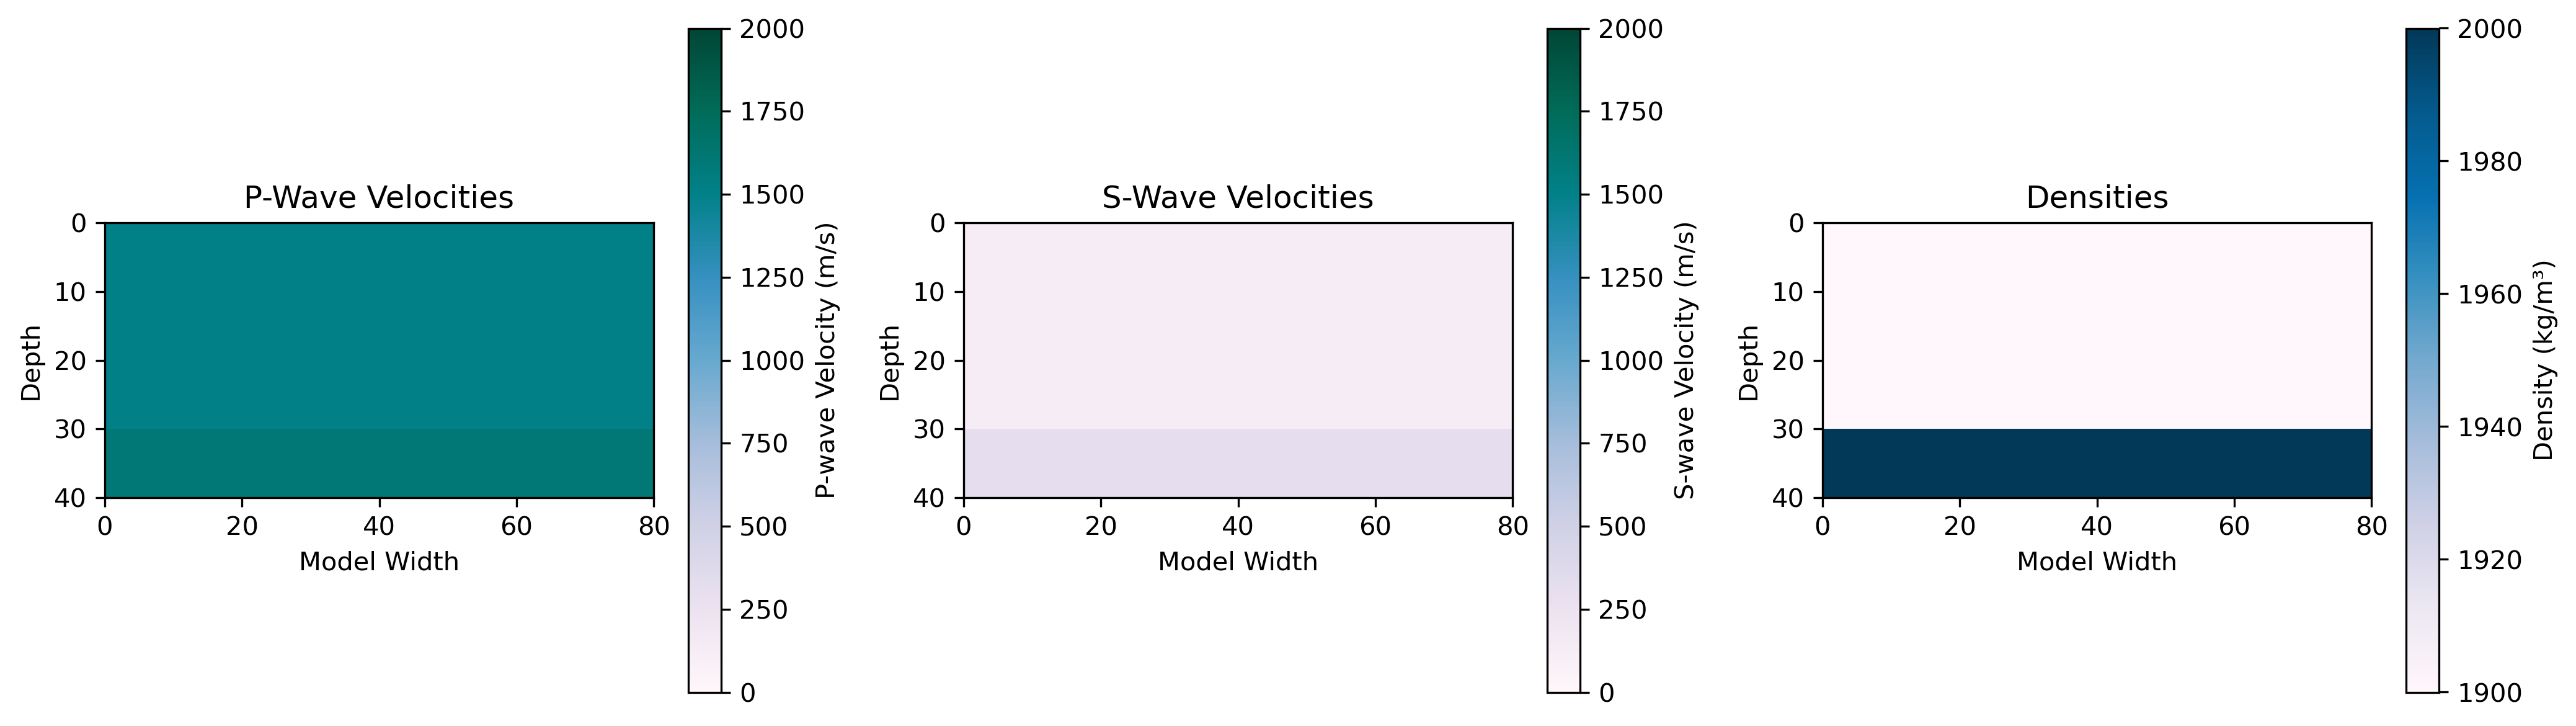

In [2]:
name = 'test'

x_model = 80
y_model = 40
dx = 0.25

xrcv1 = 10  # Initial offset
xrcv2 = 80 - 10  # Final offset
dxrcv = 1  # Receiver offset
zrcv = 0.5  # Receiver depth

source_depth = 0.5
focus_center = x_model//2

boundaries = [30]
vps = [1500, 1600]
vss = [128, 300]
ros = [1900, 2000]

# Adjusting the cumulative boundaries to explicitly include the fourth layer
cumulative_boundaries = np.cumsum([0] + boundaries + [np.sum(boundaries)])

# Adjusting the models for each parameter
p_wave_model = np.zeros((y_model, x_model))
s_wave_model = np.zeros((y_model, x_model))
density_model = np.zeros((y_model, x_model))

for i, depth in enumerate(cumulative_boundaries[:-1]):
    p_wave_model[depth:cumulative_boundaries[i+1], :] = vps[i]
    s_wave_model[depth:cumulative_boundaries[i+1], :] = vss[i]
    density_model[depth:cumulative_boundaries[i+1], :] = ros[i]

# Redoing the plots
fig, axes = plt.subplots(1, 3, figsize=(14, 4), dpi=300, sharex=True)

# P-wave velocities plot
ax = axes[0]
im = ax.imshow(p_wave_model, aspect='equal', cmap='PuBuGn', extent=[0, x_model, y_model, 0], vmin=0, vmax=2000)
fig.colorbar(im, ax=ax, label='P-wave Velocity (m/s)')
ax.set_title('P-Wave Velocities')
ax.set_xlabel('Model Width')
ax.set_ylabel('Depth')

# S-wave velocities plot
ax = axes[1]
im = ax.imshow(s_wave_model, aspect='equal', cmap='PuBuGn', extent=[0, x_model, y_model, 0], vmin=0, vmax=2000)
fig.colorbar(im, ax=ax, label='S-wave Velocity (m/s)')
ax.set_title('S-Wave Velocities')
ax.set_xlabel('Model Width')
ax.set_ylabel('Depth')

# Densities plot
ax = axes[2]
im = ax.imshow(density_model, aspect='equal', cmap='PuBu', extent=[0, x_model, y_model, 0])
fig.colorbar(im, ax=ax, label='Density (kg/m³)')
ax.set_title('Densities')
ax.set_xlabel('Model Width')
ax.set_ylabel('Depth')

# # Plot sources
# for i, ax in enumerate(axes.flatten()):
#     depth = [source_depth]*len(sources_dic.keys())
#     xdis = [x_model//2 + key[1] for key in sources_dic.keys()]
#     ax.scatter(xdis, depth, marker='+', c='red', s=20, zorder=100)

# # Plot receivers
# for i, ax in enumerate(axes.flatten()):
#     recs = np.arange(xrcv1, xrcv2, dxrcv)
#     depth = [zrcv]*len(recs)
#     ax.scatter(recs, depth, marker='*', c='orange', s=20)

plt.tight_layout()
plt.show()

In [3]:
def checkdx(vels, dx, Fmax, wav_dt, disp=5):
    """Checks if the values of dx and dt set for the modeling allow for stability in fdelmodc

    Args:
        mods (list): List of models generated previously
        dt (float, optional): value for dt of wavelet. Defaults to 0.0001.
        Fmax (float, optional): Max frequency in the wavelet. Defaults to 57.539680.
        disp (int, optional): Reference value from the manual. Defaults to 5.
    """

    Cmax = max(vels)
    Cmin = min(vels)

    need_change = False

    if wav_dt < ((0.606*dx)/Cmax):
        print('Passed the STABILITY test required for convergence, the models can be computed :)')

        if Cmin < Fmax*dx*disp:

            if (wav_dt*Cmax)/0.606 < Cmin/(Fmax*disp):
                print('There is dispersion in the parameters, be cautious, the critical value for dx is less than {:.3f}'.format(
                    Cmin/(Fmax*disp)))

                need_change = True

            else:
                print('Under the current parameters there is no real value for dx that can fix the dispersion, change the parameters of Vs or decrease dt')
                need_change = True

        else:
            print('Everything seems to be fine \U0001F600')

    else:
        print('Failed to pass the stability test, please check the values for dx (and dz as well), the critical value for dx is greater than {:.3f}'.format(
            wav_dt*Cmax/0.606))
        need_change = True

    print('\n The ranges for dx are between {:.3f} and {:.3f}'.format(
        wav_dt*Cmax/0.606, Cmin/(Fmax*disp)))

In [4]:
checkdx(vss, dx, 101, 0.0001)

Passed the STABILITY test required for convergence, the models can be computed :)
Everything seems to be fine 😀

 The ranges for dx are between 0.050 and 0.253


In [5]:
cumsums = np.cumsum(boundaries)

comm = f'makemod file_base={name}.su cp0={vps[0]} cs0={vss[0]} ro0={ros[0]} \
sizex={x_model} sizez={y_model} dx={dx} dz={dx} orig=0,0 \
intt=def poly=0 cp={vps[1]} cs={vss[1]} ro={ros[1]} x=0,{x_model} z={cumsums[0]},{cumsums[0]}  verbose=0'

# \
# intt=def poly=0 cp={vps[2]} cs={vss[2]} ro={ros[2]} x=0,{x_model} z={cumsums[1]},{cumsums[1]} \
# intt=def poly=0 cp={vps[3]} cs={vss[3]} ro={ros[3]} x=0,{x_model} z={cumsums[2]},{cumsums[2]}

os.system(f'cd {path} && {comm}')

0

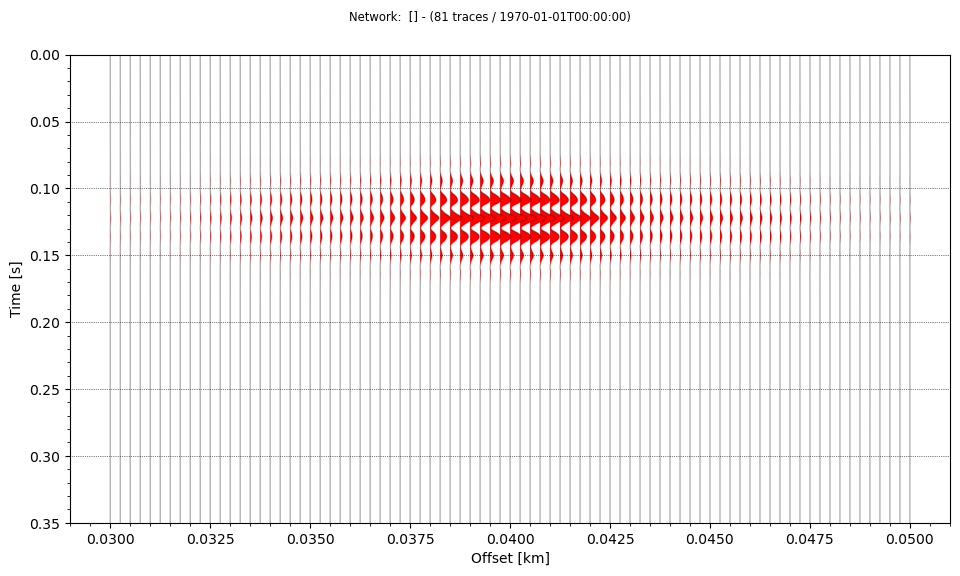

In [6]:
# Creating wavelets
# dt = 0.0001  # Stepsize in time direction
dt = 0.00008 # 0.00002
t0 = 0.23  # Position of peak wavelet
nt = (1 + t0) / dt

sources_list = []
for key in sources_dic.keys():
    _stats = obspy.core.Stats()
    _stats['delta'] = dt
    _stats['gx'] = np.float64(focus_center + key[1])
    _stats['gelev'] = np.float64(source_depth)
    _stats['npts'] = nt
    _stats['distance'] = focus_center + key[1]

    arf = sources_dic[key]
    arf = signal.resample(arf, int(len(arf)*(t_wav[1]/dt)))
    arf = np.pad(arf, (0, int(nt)-arf.size))
    arf *= 2

    # tr = obspy.Trace(data = sources_dic[key], header=_stats)
    tr = obspy.Trace(data = np.float32(arf), header=_stats)
    sources_list.append(tr)

sources_stream = obspy.Stream(sources_list)
sources_stream.plot(type='section', scale=2.5, time_down=True, recordlength=0.35, norm_method='stream', fillcolors=('r', 'b'), alpha=.3);

sources_stream.write("./Data/sources_st.su", format="SU", byteorder='<')

In [16]:
print("Length of arf:", len(arf))
print("t_wav[1]:", t_wav[1])
print("dt:", dt)
print("Calculated new length:", int(len(arf)*(t_wav[1]/dt)))


Length of arf: 15374
t_wav[1]: 0.0001
dt: 8e-05
Calculated new length: 19217


In [7]:
# SNAPSHOT PARAMETERS
tsnap1 = 0.01
tsnap2 = 0.8
dtsnap = 0.001
sna_type_ss = 1  # S (curl) registration
sna_type_pp = 1  # P (divergence) registration
sna_type_p = 1 # p registration
sna_type_vz = 1  # Vz registration
sna_type_vx = 1  # Vx registration

snap_string = ' tsnap1=%0.1f tsnap2=%.1f dtsnap=%.3f sna_type_p=%i sna_type_ss=%i sna_type_pp=%i sna_type_vz=%i sna_type_vx=%i'%(tsnap1,
                                                                                     tsnap2,
                                                                                     dtsnap,
                                                                                     sna_type_p,
                                                                                     sna_type_ss,
                                                                                     sna_type_pp,
                                                                                     sna_type_vz,
                                                                                     sna_type_vx)
print(snap_string)

 tsnap1=0.0 tsnap2=0.8 dtsnap=0.001 sna_type_p=1 sna_type_ss=1 sna_type_pp=1 sna_type_vz=1 sna_type_vx=1


In [18]:
file_src = 'sources_st.su'

dtrcv = 0.0005  # Receiver time resolution

xsrca = str([focus_center+key[1] for key in sources_dic.keys()])[1:-1].replace(' ','')
zsrca = str([source_depth]*len(sources_dic))[1:-1].replace(' ','')

path = '/home/riascodc/Documents/ARF/Code/Data'

file_cp = path + '/' + name + '_cp.su'
file_cs = path + '/' + name + '_cs.su'
file_den = path + '/' + name + '_ro.su'
file_rcv = path + '/' + name + '.su'
file_log = path + '/' + name + '.log'
file_snap = path + '/' + name + 'snap.su'

# ischeme=....... 1=acoustic, 2=visco-acoustic 3=elastic, 4=visco-elastic, 5=double-couple      

modeling = f'fdelmodc file_cp={file_cp} file_cs={file_cs} file_den={file_den} ischeme=3 file_src={file_src} \
            file_rcv={file_rcv} file_snap={file_snap} xrcv1={xrcv1} xrcv2={xrcv2} dxrcv={dxrcv} zrcv1={zrcv} zrcv2={zrcv} \
            dtrcv={dtrcv} rec_type_vx=1 rec_type_vz=1 rec_int_vx=1 xsrca={xsrca} zsrca={zsrca} \
            nshot=1 src_type=7 src_orient=1 top=1 left=4 right=4 bottom=4 ntaper=100 src_multiwav=1 src_at_rcv=0 verbose=4 > {file_log} 2>&1'

os.system(f'cd {path}/ && export OMP_NUM_THREADS=16 && {modeling + snap_string}')

0

# To run a finer wavelet

In [ ]:
# Creating wavelet
dt = 0.0001  # Stepsize in time direction
t0 = 0.23  # Position of peak wavelet
nt = (1 + t0) / dt

w = "fw"  # Type of wavelet
fmin = 20
flef = 70
frig = 360
fmax = 400

wavelet = "makewave file_out=wavelet.su dt={} nt={} t0={} w={} fmin={} flef={} frig={} fmax={} verbose=1".format(
    str(dt), str(nt), str(t0), w, str(fmin), str(flef), str(frig), str(fmax)
)

running = os.system(
    "cd {pathstr} && {wvstr}".format(pathstr=path, wvstr=wavelet)
)

if running == 0:
    print("The command executed successfully!")

waveimage = segyio.su.open("./Data/wavelet.su", endian="little")
plt.figure(figsize=(17, 3))
plt.plot(waveimage.trace[0])
waveimage.close()

In [ ]:
file_src = 'wavelet.su'

xrcv1 = 10  # Initial offset
xrcv2 = 100 - 10  # Final offset
dxrcv = 1  # Receiver offset
dtrcv = 0.0005  # Receiver time resolution
xsrc = 50  # Offset of the source
zsrc = boundaries[0] + 3

path = '/home/riascodc/Elastography/Code/Data'

file_cp = path + '/' + name + '_cp.su'
file_cs = path + '/' + name + '_cs.su'
file_den = path + '/' + name + '_ro.su'
file_rcv = path + '/' + name + '.su'
file_log = path + '/' + name + '.log'
file_snap = path + '/' + name + 'snap.su'

# ischeme=3 ......... 1=acoustic, 2=visco-acoustic 3=elastic, 4=visco-elastic, 5=double-couple 

modeling = f'fdelmodc file_cp={file_cs} file_cs={file_cs} file_den={file_den} ischeme=1 file_src={file_src} \
            file_rcv={file_rcv} file_snap={file_snap} xrcv1={xrcv1} xrcv2={xrcv2} dxrcv={dxrcv} zrcv1={zrcv} zrcv2={zrcv} \
            dtrcv={dtrcv} rec_type_vx=1 rec_type_vz=1 rec_int_vx=1 rec_int_vz=0 xsrc={xsrc} zsrc={zsrc} \
            nshot=1 src_type=7 src_orient=1 top=1 left=4 right=4 bottom=4 ntaper=100' # verbose=4 > {file_log} 2>&1'

os.system(f'cd {path}/ && export OMP_NUM_THREADS=16 && {modeling + snap_string}')

# To see the snapshots

(0.5, 0.0)

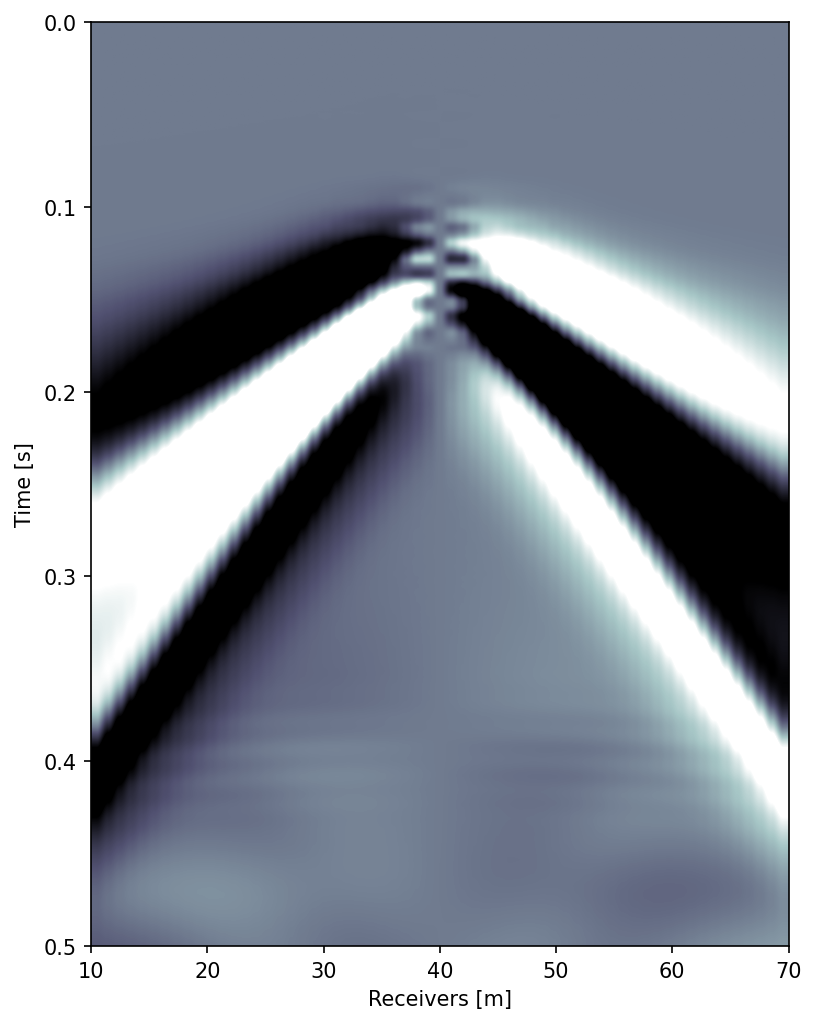

In [14]:
file = obspy.read('/home/riascodc/Documents/ARF/Code/Data/test_rvx.su')

seis = np.zeros((len(file), file[0].stats.npts), dtype = 'float32')
for ix in range(len(file)):
    seis[ix] = file[ix].data

clip = 4
divnorm = colors.TwoSlopeNorm(vmin=seis.min()/clip, vcenter=0, vmax=seis.max()/clip)

plt.figure(figsize=(6, 8), dpi=150)

plt.imshow(seis.T, aspect='auto', cmap='bone', extent=[xrcv1, xrcv2, seis.shape[1]*dtrcv, 0], norm=divnorm)

rec_axis = np.arange(xrcv1, xrcv2, dxrcv)
time_shift = 0.23

# plt.plot(rec_axis, np.sqrt((rec_axis-rec_axis[len(rec_axis)//2])**2 + 40**2)/(1500) + time_shift, c='red')
# plt.plot(rec_axis, np.sqrt((rec_axis-rec_axis[len(rec_axis)//2])**2 + 60**2)/(400) + time_shift, c='red')
# plt.plot(rec_axis, np.sqrt((rec_axis-rec_axis[len(rec_axis)//2])**2 + 80**2)/(1000) + time_shift, c='red')
plt.ylabel('Time [s]')
plt.xlabel('Receivers [m]')
plt.ylim(0.5, 0)

In [30]:
snap_vz = segyio.su.open('/home/riascodc/Documents/ARF/Code/Data/testsnap_svz.su', endian='little', ignore_geometry=True)
snap_vz = segyio.collect(snap_vz.trace)[:]
snap_vz.shape, snap_vz.min()

((257121, 161), -0.0069405194)

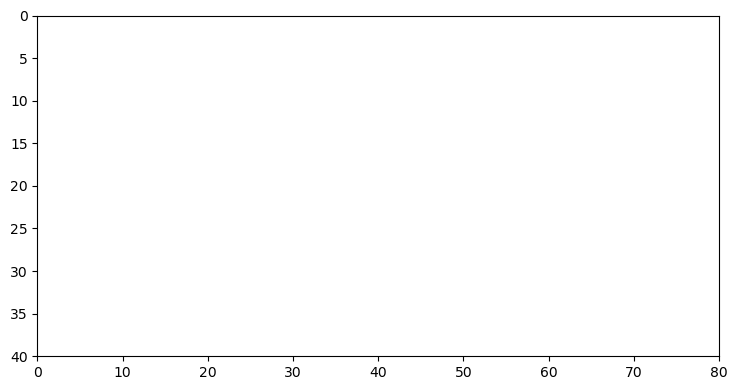

In [31]:
snap_vz = snap_vz.flatten()

nx, nz = int(x_model//dx)+1, int(y_model//dx)+1
nsnap = snap_vz.size // (nx*nz)
snap_vz = snap_vz.reshape(nsnap, nx, nz)
clip = 2
divnorm = colors.TwoSlopeNorm(vmin=snap_vz.min()/clip, vcenter=0, vmax=snap_vz.max()/clip)

fig = plt.figure(figsize=(8, 4))

camera = Camera(fig)

for i in range(0, snap_vz.shape[0]):
    plt.imshow(snap_vz[i].T, cmap='bone', norm=divnorm, aspect='equal', extent=[0, x_model, y_model, 0])
    plt.axhline(np.cumsum(boundaries)[0], c='r')
    plt.tight_layout()
    camera.snap()

animation = camera.animate(interval=12)
animation.save('sss.mp4')

## P-S interaction

In [32]:
nx, nz = int(x_model//dx)+1, int(y_model//dx)+1

snap_s = segyio.su.open('/home/riascodc/Documents/ARF/Code/Data/testsnap_sss.su', endian='little', ignore_geometry=True)
snap_s = segyio.collect(snap_s.trace)[:].flatten()

nsnap = snap_s.size // (nx*nz)
snap_s = snap_s.reshape(nsnap, nx, nz)

snap_p = segyio.su.open('/home/riascodc/Documents/ARF/Code/Data/testsnap_spp.su', endian='little', ignore_geometry=True)
snap_p = segyio.collect(snap_p.trace)[:].flatten()
snap_p = snap_p.reshape(nsnap, nx, nz)

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors

def add_alpha_to_colormap(cmap, alpha_start=1.0, alpha_end=1.0):
    """
    Add an alpha gradient to a colormap.

    Args:
    cmap (Colormap): Original colormap.
    alpha_start (float, optional): Starting alpha value. Defaults to 1.0.
    alpha_end (float, optional): Ending alpha value. Defaults to 1.0.

    Returns:
    Colormap: New colormap with alpha gradient.
    """
    cdict = cmap._segmentdata.copy()
    n_colors = 256
    alpha_vals = np.linspace(alpha_start, alpha_end, n_colors)
    cdict['alpha'] = [(i / (n_colors - 1), alpha, alpha) for i, alpha in enumerate(alpha_vals)]
    return colors.LinearSegmentedColormap('alpha_' + cmap.name, segmentdata=cdict)

# Assuming divblues and divreds are the original colormaps
cmap_divblues_alpha = add_alpha_to_colormap(plt.cm.Blues, alpha_start=0.0, alpha_end=1.0)
cmap_divreds_alpha = add_alpha_to_colormap(plt.cm.Reds, alpha_start=0.0, alpha_end=1.0)


In [35]:
s_abs = np.abs(snap_s)
p_abs = np.abs(snap_p)

In [ ]:
clip = 8
divnorm_s = colors.TwoSlopeNorm(vmin=snap_s.min()/clip, vcenter=0, vmax=snap_s.max()/clip)
divnorm_p = colors.TwoSlopeNorm(vmin=snap_p.min()/clip, vcenter=0, vmax=snap_p.max()/clip)

fig = plt.figure(figsize=(8,4))

camera = Camera(fig)

for i in range(0, snap_s.shape[0]//2):
    plt.imshow(s_abs[i].T, cmap=cmap_divblues_alpha, vmax=snap_s.max()/clip, aspect='equal', extent=[0, x_model, y_model, 0])
    plt.imshow(p_abs[i].T, cmap=cmap_divreds_alpha, vmax=snap_p.max()/150, aspect='equal', extent=[0, x_model, y_model, 0])
    plt.axhline(np.cumsum(boundaries)[0], c='r')
    plt.tight_layout()
    print(i)
    camera.snap()

animation = camera.animate(interval=20)
animation.save('p-scomp.mp4')

## Displacement estimation

In [19]:
nx, nz = int(x_model//dx)+1, int(y_model//dx)+1

snap_vz = segyio.su.open('/home/riascodc/Documents/ARF/Code/Data/testsnap_svz.su', endian='little', ignore_geometry=True)
snap_vz = segyio.collect(snap_vz.trace)[:].flatten()

nsnap = snap_vz.size // (nx*nz)
snap_vz = snap_vz.reshape(nsnap, nx, nz)

snap_vx = segyio.su.open('/home/riascodc/Documents/ARF/Code/Data/testsnap_svx.su', endian='little', ignore_geometry=True)
snap_vx = segyio.collect(snap_vx.trace)[:].flatten()
snap_vx = snap_vx.reshape(nsnap, nx, nz)

In [21]:
import numpy as np
from scipy.integrate import cumulative_trapezoid

# SNAPSHOT PARAMETERS
tsnap1 = 0.01
tsnap2 = 0.8
dtsnap = 0.001

time = np.arange(0, tsnap2+dtsnap, dtsnap)
time.shape

(801,)

In [22]:
# Integrate over time for each spatial point
disp_x = cumulative_trapezoid(snap_vx, time, axis=0, initial=0)
disp_z = cumulative_trapezoid(snap_vz, time, axis=0, initial=0)

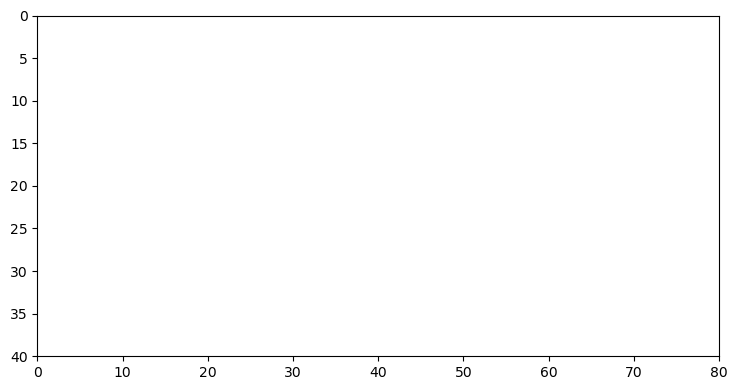

In [43]:
clip = 1
divnorm = colors.TwoSlopeNorm(vmin=disp_x.min()/clip, vcenter=0, vmax=disp_x.max()/clip)

fig = plt.figure(figsize=(8,4))

camera = Camera(fig)

for i in range(0, disp_x.shape[0]):
    plt.imshow(disp_x[i].T, cmap='RdBu', norm=divnorm, aspect='equal', extent=[0, x_model, y_model, 0])
    plt.axhline(np.cumsum(boundaries)[0], c='r')
    plt.tight_layout()
    camera.snap()

animation = camera.animate(interval=12)
animation.save('dispx.mp4')

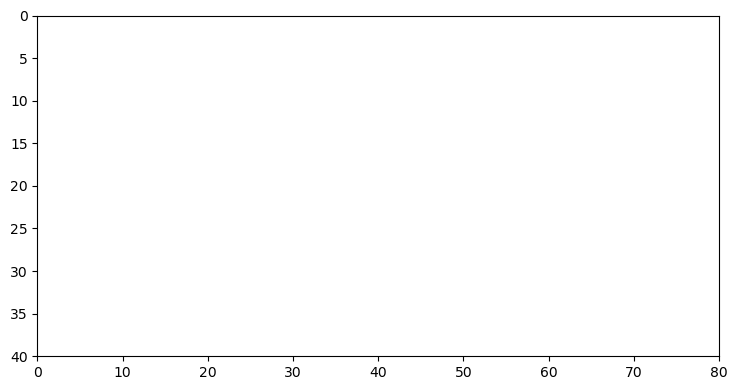

In [44]:
clip = 1
divnorm = colors.TwoSlopeNorm(vmin=disp_z.min()/clip, vcenter=0, vmax=disp_z.max()/clip)

fig = plt.figure(figsize=(8,4))

camera = Camera(fig)

for i in range(0, disp_x.shape[0]):
    plt.imshow(disp_z[i].T, cmap='RdBu', norm=divnorm, aspect='equal', extent=[0, x_model, y_model, 0])
    plt.axhline(np.cumsum(boundaries)[0], c='r')
    plt.tight_layout()
    camera.snap()

animation = camera.animate(interval=12)
animation.save('dispz.mp4')

In [23]:
total_disp = (disp_x**2 + disp_z**2)**(1/2)

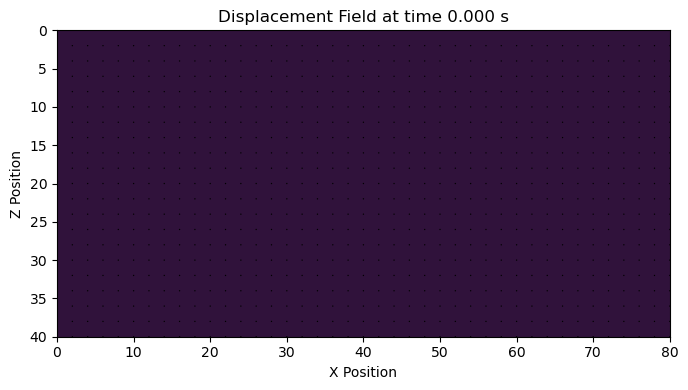

In [17]:
# Downsampling factor and meshgrid setup
factor = 8
x, z = np.meshgrid(np.linspace(0, x_model, int(x_model//dx+1)), np.linspace(0, y_model, int(y_model//dx+1)))
x_downsampled = x[::factor, ::factor]
z_downsampled = z[::factor, ::factor]

# Initialize the figure for the animation
fig, ax = plt.subplots(figsize=(8, 4))

def update(frame):
    """ Update function for the animation """
    ax.clear()  # Clear the previous quiver plot
    disp_x_slice = disp_x[frame, :, :].T / disp_z.max()
    disp_z_slice = disp_z[frame, :, :].T / disp_z.max()
    disp_x_downsampled = disp_x_slice[::factor, ::factor]
    disp_z_downsampled = disp_z_slice[::factor, ::factor]

    # Creating the quiver plot for the current frame
    quiver = ax.quiver(x_downsampled, z_downsampled, disp_x_downsampled, -disp_z_downsampled, scale=9)
    ax.imshow(total_disp[frame, :, :].T, extent=[0, x_model, y_model, 0], cmap='turbo', vmin=total_disp.min(), vmax=total_disp.max())
    ax.set_xlabel('X Position')
    ax.set_ylabel('Z Position')
    # ax.invert_yaxis()
    ax.set_title(f'Displacement Field at time {frame*dt:.3f} s')
    plt.tight_layout()

# Number of frames (adjust as needed)
num_frames = disp_z.shape[0] 

# Creating the animation
ani = FuncAnimation(fig, update, frames=range(0, num_frames, 1), interval=20)

#plt.show()
# Uncomment the following line to save the animation
ani.save('displacement_animation_color.mp4', writer='ffmpeg')


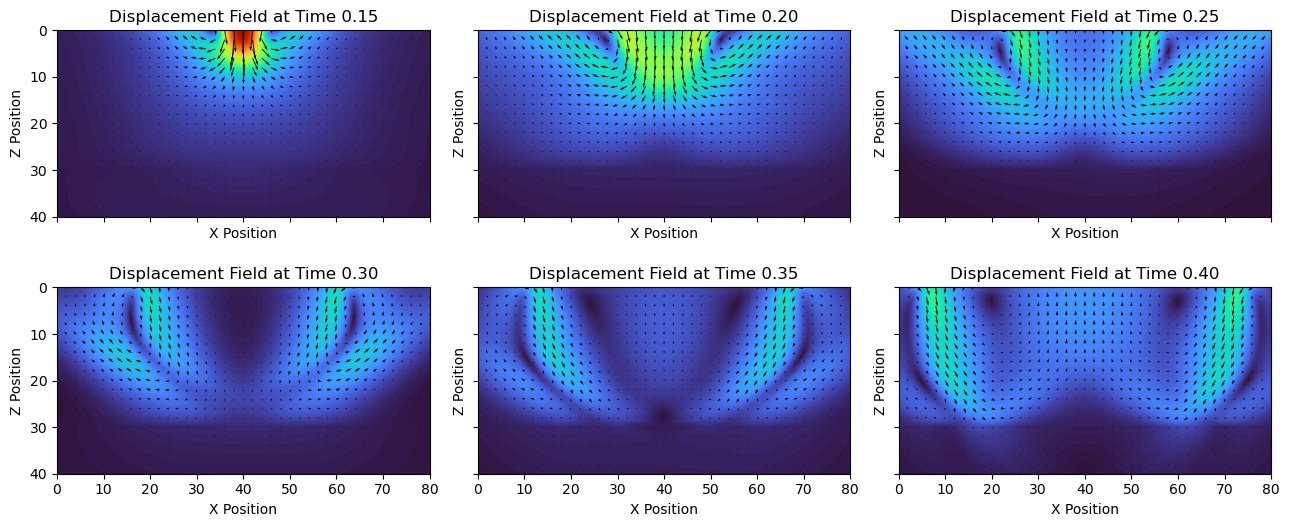

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import colorcet as cc

# Downsampling factor and meshgrid setup
factor = 8
x, z = np.meshgrid(np.linspace(0, x_model, int(x_model//dx+1)), np.linspace(0, y_model, int(y_model//dx+1)))
x_downsampled = x[::factor, ::factor]
z_downsampled = z[::factor, ::factor]

# Initialize the figure for subplots
fig, axs = plt.subplots(2, 3, figsize=(13, 5.5), sharey=True, sharex=True)  # 2x2 grid of plots
axs = axs.flatten()  # Flatten the array to make it easier to index

# Time frames to plot
time_frames = [150, 200, 250, 300, 350, 400]  # Adjust these to the frames you want to plot

for i, frame in enumerate(time_frames):
    disp_x_slice = disp_x[frame, :, :].T / disp_z.max()
    disp_z_slice = disp_z[frame, :, :].T / disp_z.max()
    disp_x_downsampled = disp_x_slice[::factor, ::factor]
    disp_z_downsampled = disp_z_slice[::factor, ::factor]

    # Creating the quiver plot for the current frame
    axs[i].quiver(x_downsampled, z_downsampled, disp_x_downsampled, -disp_z_downsampled, scale=14)
    im = axs[i].imshow(total_disp[frame, :, :].T, extent=[0, x_model, y_model, 0], cmap='turbo', vmin=total_disp.min(), vmax=total_disp.max())

    axs[i].set_xlabel('X Position')
    axs[i].set_ylabel('Z Position')
    axs[i].set_title(f'Displacement Field at Time {frame*dtsnap:.2f}')

plt.tight_layout()

# Add a colorbar to the figure based on the last imshow
#fig.colorbar(im, ax=axs, orientation='horizontal', fraction=0.02, pad=0.04)

plt.show()

# Assuming disp_x, disp_z, total_disp, x_model, y_model, dx, and dtsnap are all defined and correctly populated
#np.savez('../Images/img_npy/displacement.npz', disp_x=disp_x, disp_z=disp_z, total_disp=total_disp, x_model=x_model, y_model=y_model, dx=dx, dtsnap=dtsnap)


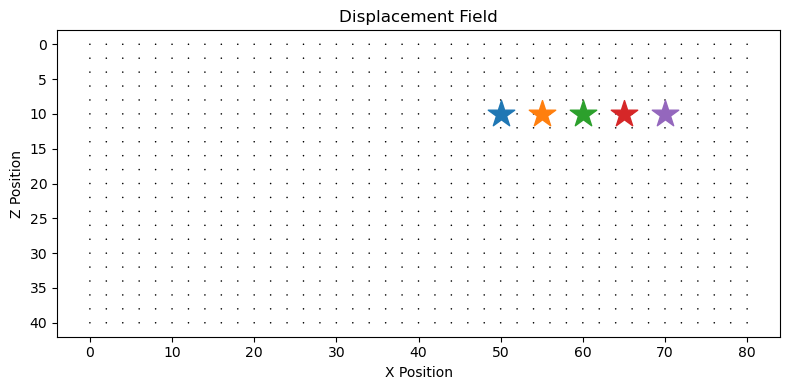

In [18]:
# Downsampling factor and meshgrid setup
factor = 8
x, z = np.meshgrid(np.linspace(0, x_model, int(x_model//dx+1)), np.linspace(0, y_model, int(y_model//dx+1)))
x_downsampled = x[::factor, ::factor]
z_downsampled = z[::factor, ::factor]

# Initialize the figure for the animation
fig, ax = plt.subplots(figsize=(8, 4))

def update(frame):
    """ Update function for the animation """
    ax.clear()  # Clear the previous quiver plot
    disp_x_slice = disp_x[frame, :, :].T / disp_z.max()
    disp_z_slice = disp_z[frame, :, :].T / disp_z.max()
    disp_x_downsampled = disp_x_slice[::factor, ::factor]
    disp_z_downsampled = disp_z_slice[::factor, ::factor]

    # Creating the quiver plot for the current frame
    quiver = ax.quiver(x_downsampled, z_downsampled, disp_x_downsampled, -disp_z_downsampled, scale=9)
    ax.set_xlabel('X Position')
    ax.set_ylabel('Z Position')
    ax.invert_yaxis()
    ax.set_title('Displacement Field')
    ax.scatter(50, 10, marker='*', s=400)
    ax.scatter(55, 10, marker='*', s=400)
    ax.scatter(60, 10, marker='*', s=400)
    ax.scatter(65, 10, marker='*', s=400)
    ax.scatter(70, 10, marker='*', s=400)

    plt.tight_layout()

# Number of frames (adjust as needed)
num_frames = disp_z.shape[0] //2 

# Creating the animation
ani = FuncAnimation(fig, update, frames=range(0, num_frames, 1), interval=20)

#plt.show()
# Uncomment the following line to save the animation
# ani.save('dispexper.mp4', writer='ffmpeg')

Text(0, 0.5, 'Vertical displacement [m]')

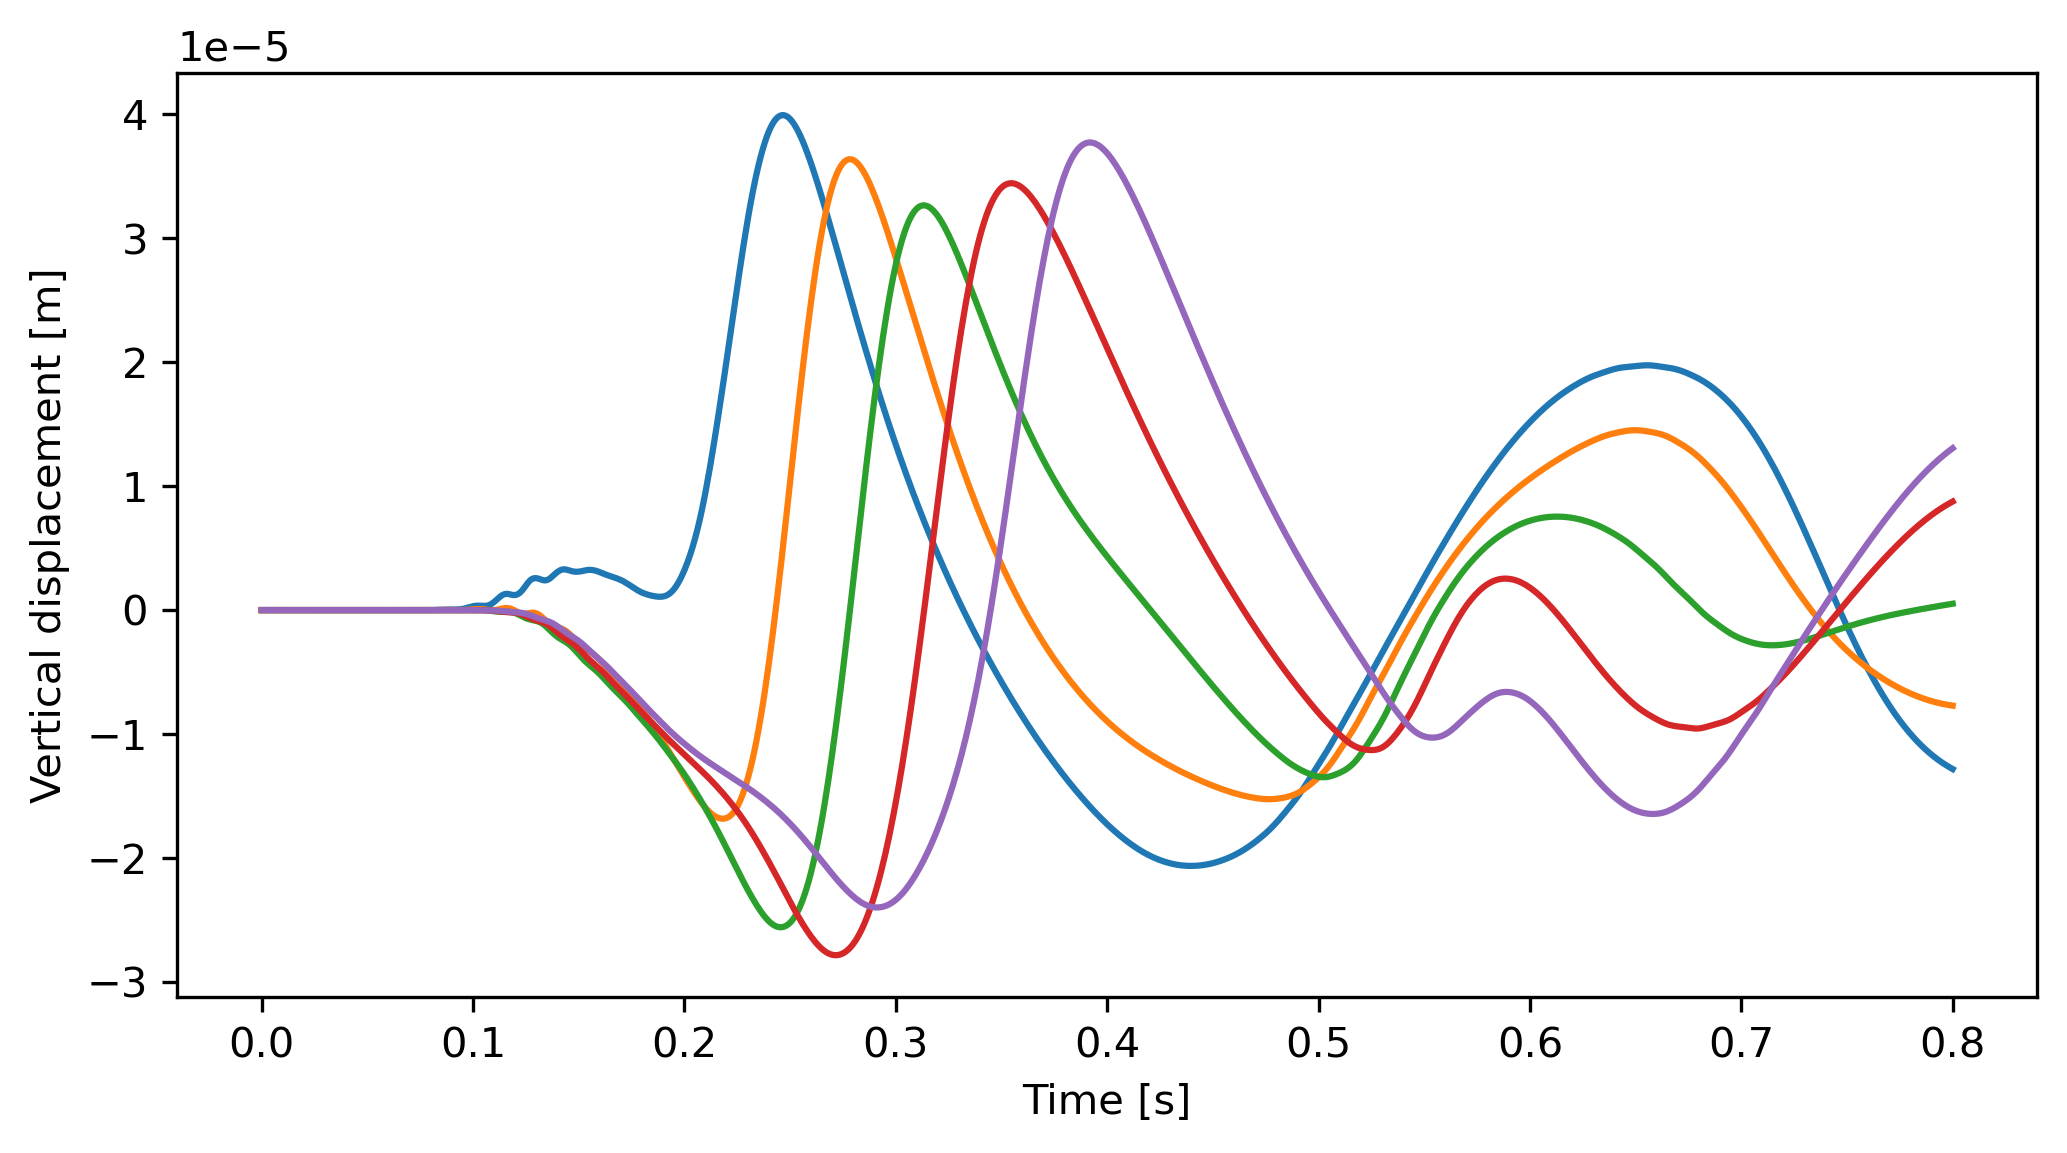

In [21]:
plt.figure(dpi=300, figsize=(8, 4))

plt.plot(time, disp_z[:, int(50//dx), int(10//dx)])
plt.plot(time, disp_z[:, int(55//dx), int(10//dx)])
plt.plot(time, disp_z[:, int(60//dx), int(10//dx)])
plt.plot(time, disp_z[:, int(65//dx), int(10//dx)])
plt.plot(time, disp_z[:, int(70//dx), int(10//dx)])

plt.xlabel('Time [s]')
plt.ylabel('Vertical displacement [m]')

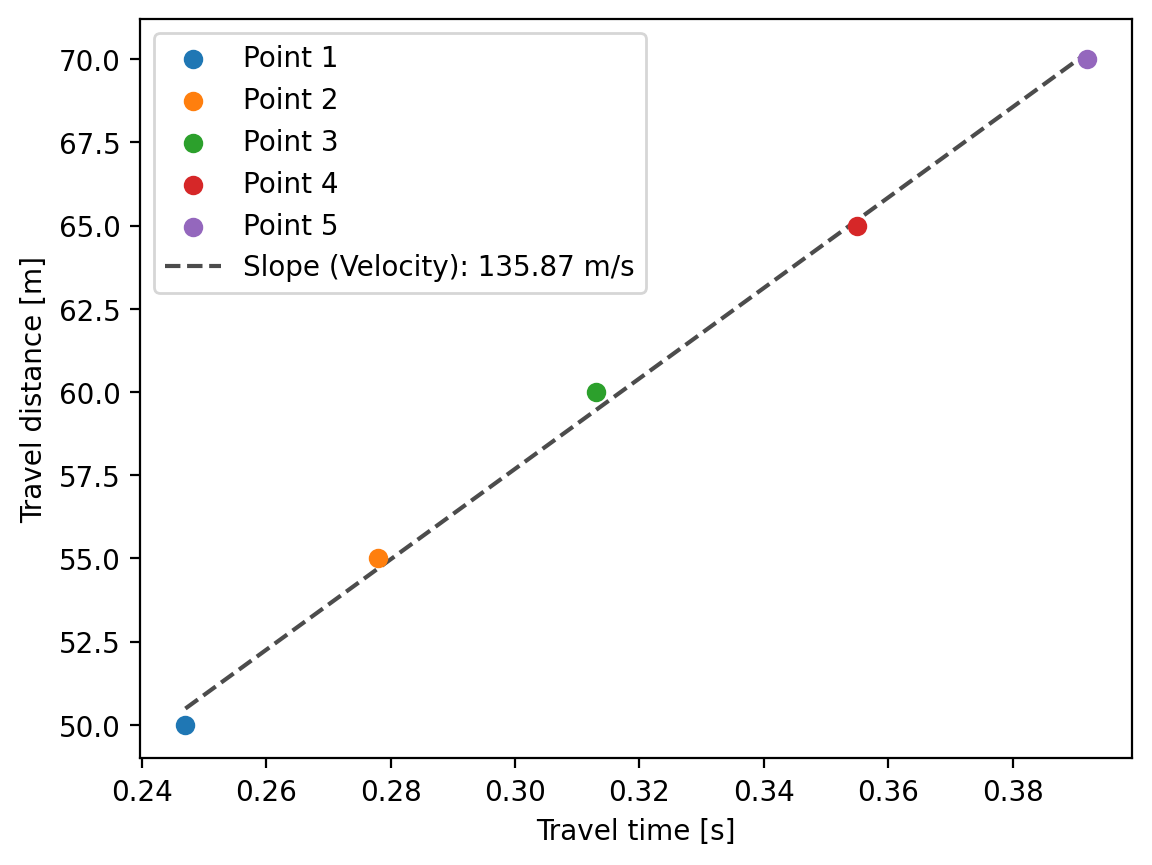

In [21]:
import numpy as np
import matplotlib.pyplot as plt

# Your data
distances = [50, 55, 60, 65, 70]
times = np.array([time[disp_z[:, int(i//dx), int(10//dx)].argmax()] for i in distances])

# Perform linear regression to fit a line
slope, intercept = np.polyfit(times, distances, 1)

# Now use the slope and intercept to create the line
timeaxis = np.linspace(times[0], times[-1], 100)
disaxis = slope * timeaxis + intercept

# Plotting the data and the fit line
plt.figure(dpi=200)
for i in range(5):
    plt.scatter(times[i], distances[i], label=f'Point {i+1}')

plt.plot(timeaxis, disaxis, '--', alpha=0.7, c='k', zorder=0, label=f'Slope (Velocity): {slope:.2f} m/s')

plt.xlabel('Travel time [s]')
plt.ylabel('Travel distance [m]')
plt.legend()
plt.show()


In [24]:
disp_x.max()*1000, disp_z.max()*1000

(0.011758949604692369, 0.03337135732376737)